# Welcome (again) to IN-STK 5k

## About Dirk

<img src="img/dirk.jpeg" width="30%">

- Associate Professor at UiO since 2018.
- Background in computational physics.
- Vice President Marketing and Supply @ Equinor
  - IT solutions for commodity trading (incl. algo-trading) and distribution.
- Experience from consulting and a start-up.
- *No office-hours*, usually at UiO on Wednesdays

## What Data Science is about

- Data Science includes
  - Statistics
  - Computer Science
  - Business Understanding
  
Data Science deals with the **interfaces of and overlaps** between
computer science, statistics, and business (decision making)
concepts. How does one, using statistical methods and CS concepts,
take sound business decisions?

Communication and presentation skills are extremely important.

<img src="img/Data_Science_VD.png" style="width: 40vw">

## Why Data-Driven Decision Making?

- In traditional business models humans take most decisions
- This doesn't *scale* well
  - Making more decisions takes more employees, and costs more
	- E.g. selling more loans
	- Shipping more products
- Business outcomes scale linearly in classical business models
  - Often even worse-than-linear due to inefficiencies at scale

  In **data-driven decision making**, we build a model based on data, predicting outcomes, and take decisions (automated or with a human in the loop) based on those predictions.

## Challenges and Dilemmas

- Fairness: Are we treating individuals fairly?
- Privacy: Are we respecting people's privacy?
- Explainability and interpretability: How can we stand behind and trust in our models' predictions?

All these will be addressed and focused on **during this course**.

### Try it yourself:

    As an exercise, brainstorm applications for data-driven decision making with ChatGPT and explore where these or other challenges and dilemmas apply! Does ChatGPT do a good job at identifying challenges?

# Rotating Equipment Business Case

A company is running a fleet of machines, e.g. gas turbines. These have operating parameters (RPM, voltage, temperature, current, etc.) which are correlated. Outliers might indicate imminent failure which can incur high costs.

In a non-data-driven business case, one might employ engineers to monitor the equipment. This does not scale well since for each N new turbines, an additional engineer needs to be employed, and with those support staff etc.

In a data-driven case, we might want to employ ML to establish a pattern and look for outliers.

In [1]:
import numpy as np
import pandas as pd

In [53]:
class RotatingEquipment():

    def __init__(self, N_train:int = 800, N_eval:int = 200, N_test:int = 200,
                 anomaly: bool = True):
        N = N_train + N_test + N_eval
        speed = np.cumsum(np.random.choice([-1., 1.], size=N))
        speed -= speed.min()*2
        self.alpha = 1. + np.random.rand()
        temperature = speed*self.alpha + \
          np.random.normal(scale=0.1, size=N)*self.alpha*speed
        self.X_train = pd.DataFrame({'speed': speed[:N_train],
                                     'temperature': temperature[:N_train]})
        self.X_test = pd.DataFrame({'speed': speed[N_train:N_train+N_test],
                                     'temperature': temperature[N_train:N_train+N_test]})
        self.X_eval = pd.DataFrame({'speed': speed[N_train+N_test:],
                                     'temperature': temperature[N_train+N_test:]})
        if anomaly:
            self.X_eval['temperature'][:20] *= 1 + np.sin(np.linspace(0, np.pi, 20))*0.5

<Axes: >

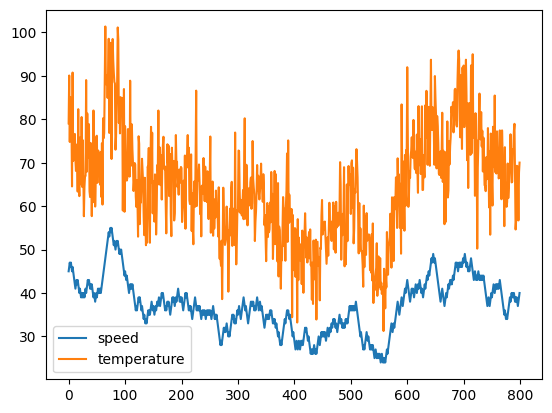

In [54]:
RotatingEquipment().X_train.plot.line()

<Axes: >

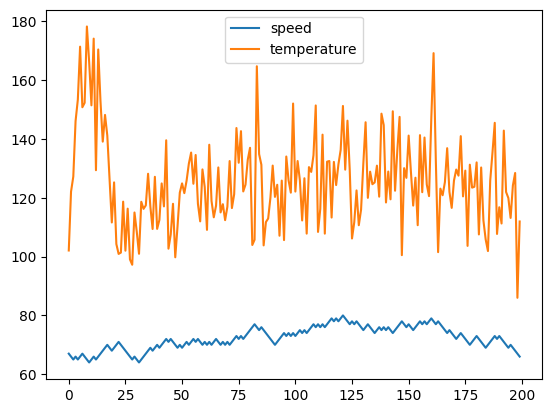

In [55]:
RotatingEquipment().X_eval.plot.line()

In [47]:
from sklearn.linear_model import LinearRegression

In [48]:
class EquipmentWatcher():

    def __init__(self, r: RotatingEquipment, sigmas:float = 3.):
        self.sigmas = sigmas
        self.model = LinearRegression().fit(r.X_train[['speed']], r.X_train['temperature'])
        self.test_error = self.model.predict(r.X_test[['speed']]) - r.X_test['temperature']
        self.eval_error = self.model.predict(r.X_eval[['speed']]) - r.X_eval['temperature']

    def anomalous(self):
        return any(np.abs(self.eval_error) > self.test_error.std()*self.sigmas)

In [49]:
EquipmentWatcher(RotatingEquipment()).anomalous()

True

In [60]:
def print_stats(N:int = 1_000, sigmas:float = 3., WatcherClass=EquipmentWatcher):
    # BALANCED training set!
    signal = np.array([WatcherClass(RotatingEquipment(anomaly=True),
                                        sigmas=sigmas).anomalous()
              for _ in range(N)])
    false_negative_rate = (signal == False).sum()/2/N # WARNING, DON'T TAKE SERIOUSLY
    true_positive_rate = (signal == True).sum()/2/N
    signal = np.array([WatcherClass(RotatingEquipment(anomaly=False),
                                        sigmas=sigmas).anomalous()
              for _ in range(N)])
    true_negative_rate = (signal == False).sum()/2/N # WARNING, DON'T TAKE SERIOUSLY
    false_positive_rate = (signal == True).sum()/2/N
    print(f"""
TPR = {true_positive_rate}
TNR = {true_negative_rate}
FPR = {false_positive_rate} <- unneeded maintenance
FNR = {false_negative_rate} <- equipment failure
""")

In [56]:
print_stats()


TPR = 0.4985
TNR = 0.2405
FPR = 0.2595 <- unneeded maintenance
FNR = 0.0015 <- equipment failure



In [57]:
print_stats(sigmas=6.)


TPR = 0.353
TNR = 0.496
FPR = 0.004 <- unneeded maintenance
FNR = 0.147 <- equipment failure



## Network Effects

- More scaling leads to more data
- More data leads to better models
- Better models lead to better scaling

<Axes: >

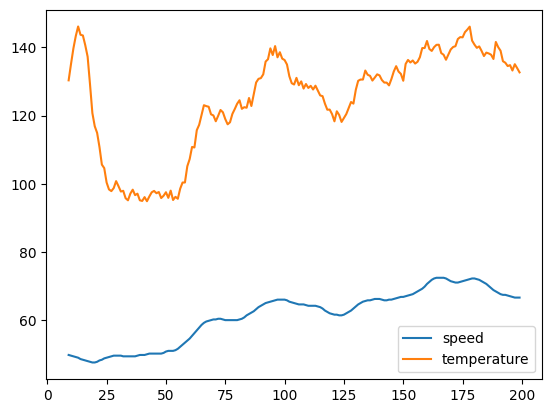

In [59]:
RotatingEquipment(anomaly=True).X_eval.rolling(10).mean().plot.line()

In [61]:
class SmoothEquipmentWatcher():

    def __init__(self, r: RotatingEquipment, sigmas:float = 3.):
        self.sigmas = sigmas
        X_train, X_test, X_eval = [X.rolling(10).mean().dropna() for X in
                                   [r.X_train, r.X_test, r.X_eval]]
        self.model = LinearRegression().fit(X_train[['speed']], X_train['temperature'])
        self.test_error = self.model.predict(X_test[['speed']]) - X_test['temperature']
        self.eval_error = self.model.predict(X_eval[['speed']]) - X_eval['temperature']

    def anomalous(self):
        return any(np.abs(self.eval_error) > self.test_error.std()*self.sigmas)

In [62]:
print_stats(sigmas=6, WatcherClass=SmoothEquipmentWatcher)


TPR = 0.498
TNR = 0.4935
FPR = 0.0065 <- unneeded maintenance
FNR = 0.002 <- equipment failure



In [63]:
print_stats(sigmas=6, WatcherClass=EquipmentWatcher)


TPR = 0.357
TNR = 0.4935
FPR = 0.0065 <- unneeded maintenance
FNR = 0.143 <- equipment failure



## Business Understanding

- Understanding the aim of automating decision making is
  *context dependent*.
- Hard to teach specifics ...
- We will however see how a specific business context can be
  approached and what questions a data scientist should ask.
- This is equally important in industry and many areas in academia.

<img src="img/business-foto.webp" style="width: 40vw">


## The Business Case


<img src="img/target.jpeg" style="width: 40vw">


- A **business objective** can be many things
  - Profit in a public company
  - Maximize the number of people saved by vaccine
  - Remove maximum amount of CO2 from a process
- A **business case** is a prescription of how to achieve the business
  objective in a project or activity

# The Rotating Equipment Business Case

- To double output, the workforce of maintenance workers needs to more than double
    - Due to inefficiencies, support staff, bureaucracy, etc.
- To double output in a data-driven case, less than doubling of resources is needed
    - More data leads to better decisions

## We saw there was a tradeoff between failures detected and unneeded maintenance

- What is the cost of a failure?
- What is the cost of maintenance?
    - Often, facilities need to be shut down and production is lost, potentially at high cost

## Dilemmas and challenges

- What if a failure is not detected and people, the environment, or economic outcomes harmed?
    - Who is responsible?
    - How likely is this to happen?
    - How do we know our model works?


# Other Scenarios for Data-Driven Decision Making

- Scaling (as we discussed)
  - Customization, decisions at scale
- Time-critical applications
  - Algo-trading, recommendations at scale, etc.
- High-precision, or high-dimensional cases
  - Computer vision (radiology), GenAI